<a href="https://colab.research.google.com/github/Anjalichimnani/EVA4/blob/master/Assignment_5/EVA4_MNIST_Final_Step_Capacity_FC_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture Insights:

**Target**: The final step to reach the desird target which is obtained by increasing the capacity of the model, adding fully connected layer after GAP (to prevent one hot vector) and image augmentation via transforms for Rotation and color jitter, added in both Train and Test data set. 

**Result**: 
  * Parameters: 9,496
  * Epochs: 15
  * Maximum Train Accuracy: 98.86
  * Maximum Test Accuracy: 99.31

**Analysis**: 
  * Model is not overfitting since it allows learning to reach its desired test accuracy
  * Parameters involved are optimized. 
  * Transforms enable to achieve the good accuracy with less cost by training in appropriate manner. 

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [135]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels = 1,out_channels = 10, kernel_size = (3, 3), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=10),
            nn.Dropout(p = 0.075),
            nn.ReLU()
        )#26

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = (3, 3), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=20),
            nn.Dropout(p = 0.075),
            nn.ReLU()
        )#24

        #Transition Block 1
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels = 20, out_channels = 10, kernel_size = (1, 1), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=10),
            nn.Dropout(p = 0.075),
            nn.ReLU()
        )#12

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels = 10,out_channels = 15, kernel_size = (3, 3), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=15),
            nn.Dropout(p = 0.075),
            nn.ReLU()
        )#10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels = 15, out_channels = 18, kernel_size = (3, 3), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=18),
            nn.Dropout(p = 0.075),
            nn.ReLU()
        )#8
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels = 18, out_channels = 20, kernel_size = (3, 3), padding = 0, bias = False),
            nn.BatchNorm2d(num_features=20),
            nn.Dropout(p = 0.075),
            nn.ReLU()
        )#6

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels = 20,out_channels = 10, kernel_size = (1, 1), padding = 0, bias = False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [137]:
!pip install torchsummary
!pip install tqdm -U

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.43.0)
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
       BatchNorm2d-6           [-1, 20, 24, 24]              40
           Dropout-7           [-1, 20, 24, 24]               0
              ReLU-8           [-1, 20, 24, 24]               0
         MaxPool2d-9           [-1, 20, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             200
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
          

In [0]:
from tqdm.notebook import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx}')
    train_acc.append(100*correct/processed)

  print ('\n\nTrain Set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss, correct, processed, 100. * correct/processed
    ))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [141]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0





Train Set: Average Loss: 0.1472, Accuracy: 47011/60000 (78.35%)


Test set: Average loss: 0.1303, Accuracy: 9727/10000 (97.27%)

EPOCH: 1





Train Set: Average Loss: 0.0858, Accuracy: 58069/60000 (96.78%)


Test set: Average loss: 0.0694, Accuracy: 9821/10000 (98.21%)

EPOCH: 2





Train Set: Average Loss: 0.0901, Accuracy: 58594/60000 (97.66%)


Test set: Average loss: 0.0548, Accuracy: 9844/10000 (98.44%)

EPOCH: 3





Train Set: Average Loss: 0.0701, Accuracy: 58798/60000 (98.00%)


Test set: Average loss: 0.0484, Accuracy: 9859/10000 (98.59%)

EPOCH: 4





Train Set: Average Loss: 0.0415, Accuracy: 58897/60000 (98.16%)


Test set: Average loss: 0.0454, Accuracy: 9852/10000 (98.52%)

EPOCH: 5





Train Set: Average Loss: 0.0520, Accuracy: 59013/60000 (98.36%)


Test set: Average loss: 0.0420, Accuracy: 9875/10000 (98.75%)

EPOCH: 6





Train Set: Average Loss: 0.0433, Accuracy: 59076/60000 (98.46%)


Test set: Average loss: 0.0372, Accuracy: 9883/10000 (98.83%)

EPOCH: 7





Train Set: Average Loss: 0.0389, Accuracy: 59126/60000 (98.54%)


Test set: Average loss: 0.0327, Accuracy: 9896/10000 (98.96%)

EPOCH: 8





Train Set: Average Loss: 0.0371, Accuracy: 59138/60000 (98.56%)


Test set: Average loss: 0.0349, Accuracy: 9892/10000 (98.92%)

EPOCH: 9





Train Set: Average Loss: 0.0626, Accuracy: 59188/60000 (98.65%)


Test set: Average loss: 0.0317, Accuracy: 9901/10000 (99.01%)

EPOCH: 10





Train Set: Average Loss: 0.0135, Accuracy: 59224/60000 (98.71%)


Test set: Average loss: 0.0309, Accuracy: 9909/10000 (99.09%)

EPOCH: 11





Train Set: Average Loss: 0.0665, Accuracy: 59223/60000 (98.70%)


Test set: Average loss: 0.0316, Accuracy: 9907/10000 (99.07%)

EPOCH: 12





Train Set: Average Loss: 0.0605, Accuracy: 59226/60000 (98.71%)


Test set: Average loss: 0.0289, Accuracy: 9910/10000 (99.10%)

EPOCH: 13





Train Set: Average Loss: 0.0715, Accuracy: 59266/60000 (98.78%)


Test set: Average loss: 0.0308, Accuracy: 9909/10000 (99.09%)

EPOCH: 14





Train Set: Average Loss: 0.0199, Accuracy: 59232/60000 (98.72%)


Test set: Average loss: 0.0265, Accuracy: 9914/10000 (99.14%)

EPOCH: 15





Train Set: Average Loss: 0.0569, Accuracy: 59315/60000 (98.86%)


Test set: Average loss: 0.0243, Accuracy: 9931/10000 (99.31%)



Text(0.5, 1.0, 'Test Accuracy')

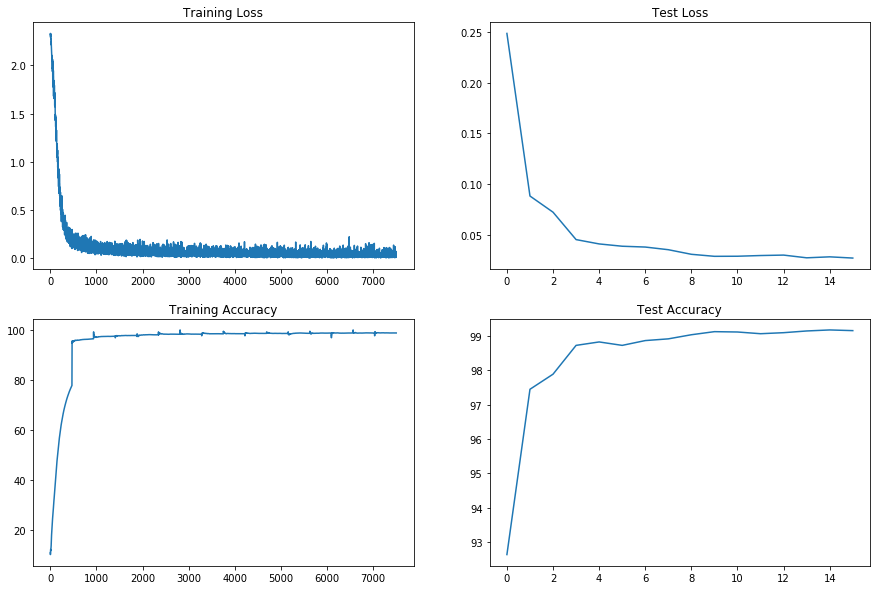

In [140]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")